In [ ]:
import numpy as np
import pandas as pd
#from scipy.signal import savgol_filter

df_weather2 = pd.read_csv('/Users/Desktop/df_weather2.csv',parse_dates=['DateOfCancel','DateOfService'])
df_weather2=df_weather2.drop(columns='Unnamed: 0')


In [24]:
df_weather2['CanceledQty'].unique()

array([0, 1, 2])

In [29]:
df_weather2['cancel_timing'].unique()

array(['no_cancel', '>5d', '2-5d', '<=1d'], dtype=object)

In [5]:
df_weather2=df_weather2.drop(columns='Unnamed: 0')

In [4]:
###### vif after incorporating the weather varibales for df_encoded
#### do the vif check
from statsmodels.stats.outliers_influence import variance_inflation_factor
num_cols = df_weather2.select_dtypes(include=[np.number]).columns.to_list()

drop_col = ['DateOfOrder', 'DateOfService','days_to_cancel','CanceledQty','OrderId', 'TransactionId','cancel_timing','BookingNr','DateOfCancel','net_qty']

vif_col_1 = [c for c in num_cols if c not in drop_col]

vif_dat_1 = df_weather2[vif_col_1].copy()
vif_dat_1.replace([np.inf,-np.inf],np.nan,inplace=True)
vif_dat_1 = vif_dat_1.dropna()
vif_scores_1 = [variance_inflation_factor(vif_dat_1,i)
              for i in range(vif_dat_1.shape[1])
              ]

vif_table_1 = (pd.DataFrame({'feature':vif_col_1,'VIF':vif_scores_1}).sort_values('VIF',ascending=False).reset_index(drop=True))
print('VIF values')
display(vif_table_1)

hg_vif_1 = vif_table_1.loc[vif_table_1['VIF']>10,'feature'].to_list()
print('the high vif columns dropped')
df_without_vif_1 = vif_dat_1.drop(columns=hg_vif_1)
print(df_without_vif_1.columns)

VIF values


,feature,VIF
0,evening,3.763506e+11
1,morning,1.221464e+11
2,afternoon,2.383254e+10
3,day_of_year,2.804066e+04
4,month,2.782194e+04
5,day_of_month,1.172699e+02
6,quarter,2.202815e+01
7,MenuSubsidy,6.193507e+00
8,MenuPrice,6.131869e+00
9,order_hour,5.326629e+00


the high vif columns dropped
Index(['OrderQty', 'MenuPrice', 'MenuSubsidy', 'weekday', 'is_weekend',
       'sin_doy', 'cos_doy', 'is_month_end', 'is_month_start', 'order_hour',
       'hist_cancel_rate', 'is_holiday', 'tavg_C', 'prcp_mm', 'rain_flag',
       'temp_dev'],
      dtype='object')


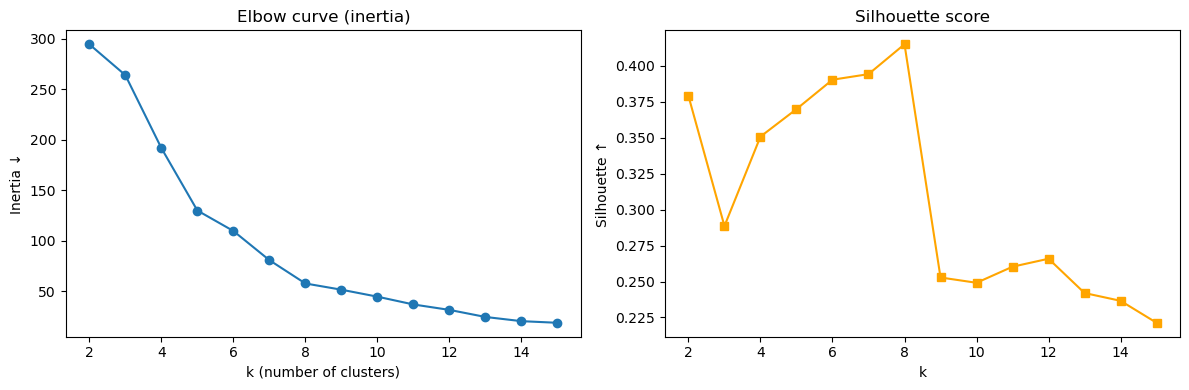

In [53]:
# ----------------------------------------------------------
# 0.  CONFIG – tweak freely
# ----------------------------------------------------------
group_keys   = ['Site', 'MenuBase']                 # as in ClusterTransformer
profile_cols = [                                    # <- add / remove features!
    'hist_cancel_rate', 'rain_flag','temp_dev','sin_doy', 'cos_doy', 'is_month_end', 'is_month_start','tavg_C', 'prcp_mm']

k_grid       = range(2, 16)                         # try k = 2 … 15
sample_frac  = 1.0                                  # 1.0 = use *all* profiles
random_state = 42

# ----------------------------------------------------------
# 1.  Build one profile row per Site×MenuBase
# ----------------------------------------------------------
prof = (
    df_weather2
      .groupby(group_keys)[profile_cols]
      .mean()
      .reset_index()
)

# optional sampling – handy if you have >50 k profiles
if sample_frac < 1.0:
    prof = prof.sample(frac=sample_frac, random_state=random_state)

# ----------------------------------------------------------
# 2.  Standardise numeric features
# ----------------------------------------------------------
from sklearn.preprocessing import StandardScaler
scaler      = StandardScaler().fit(prof[profile_cols])
X_profiles  = scaler.transform(prof[profile_cols])

# ----------------------------------------------------------
# 3.  Loop over k, collect inertia and silhouette
# ----------------------------------------------------------
from sklearn.cluster import KMeans
from sklearn.metrics  import silhouette_score
import numpy as np

elbows      = []
silhouettes = []

for k in k_grid:
    km  = KMeans(n_clusters=k, random_state=random_state, n_init='auto').fit(X_profiles)
    y_k = km.labels_
    
    # inertia (within-cluster SSE) – lower is better
    elbows.append(km.inertia_)
    
    # silhouette – higher is better (needs >1 cluster & <n_samples)
    sil = silhouette_score(X_profiles, y_k, metric='euclidean')
    silhouettes.append(sil)

# ----------------------------------------------------------
# 4.  Plot: elbow + silhouette
# ----------------------------------------------------------
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))

ax1.plot(k_grid, elbows, marker='o')
ax1.set_title("Elbow curve (inertia)")
ax1.set_xlabel("k (number of clusters)")
ax1.set_ylabel("Inertia ↓")

ax2.plot(k_grid, silhouettes, marker='s', color='orange')
ax2.set_title("Silhouette score")
ax2.set_xlabel("k")
ax2.set_ylabel("Silhouette ↑")

plt.tight_layout()
plt.show()


Hold-out period : 2024-01-05 → 2024-08-27
Train rows      : 4966195
Hold-out rows   : 601


FileNotFoundError: [Errno 2] No such file or directory: '/Users/sage/Desktop/plots/split_timeline.png'

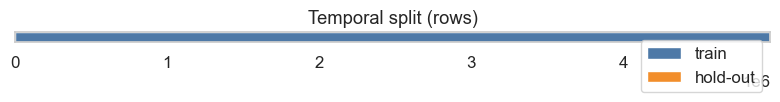

In [ ]:
# choose a cut-off: the most-recent full month in the data ----------------

df = df_weather2.copy()
df["DateOfOrder"] = pd.to_datetime(df["DateOfOrder"], errors="coerce")

cutoff = pd.Timestamp("2024-01-01")      # everything from 1 Jul 2023 onward = hold-out

mask_holdout = df["DateOfOrder"] >= cutoff          # bool mask
df_hold  = df[ mask_holdout].copy()
df_train = df[~mask_holdout].copy()

print("Hold-out period :", df_hold["DateOfOrder"].min().date(),
      "→", df_hold["DateOfOrder"].max().date())
print("Train rows      :", len(df_train) )
print("Hold-out rows   :", len(df_hold)  )



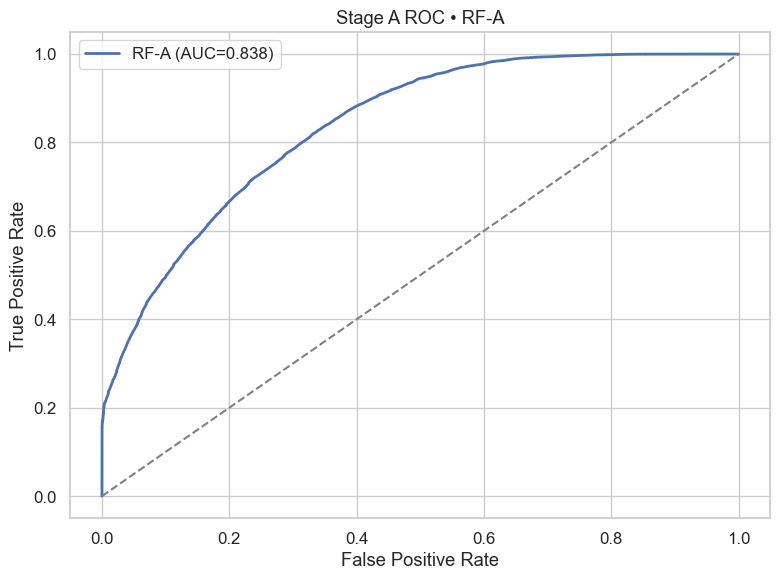

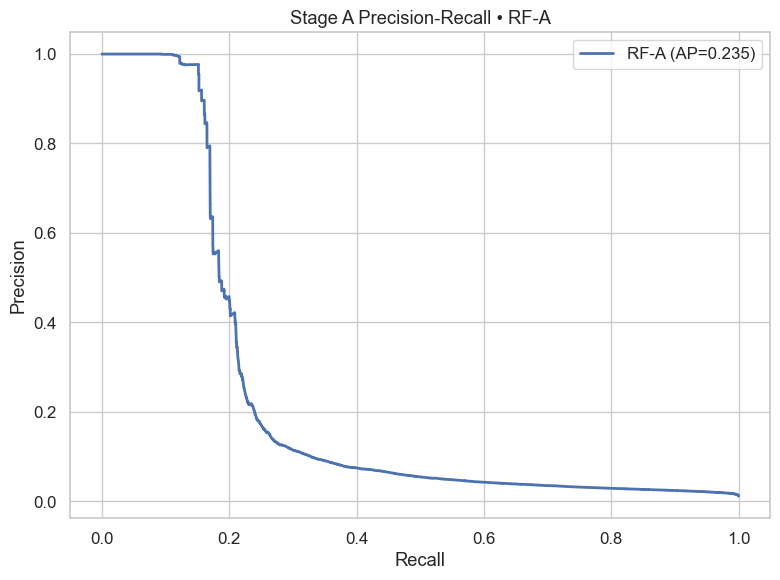

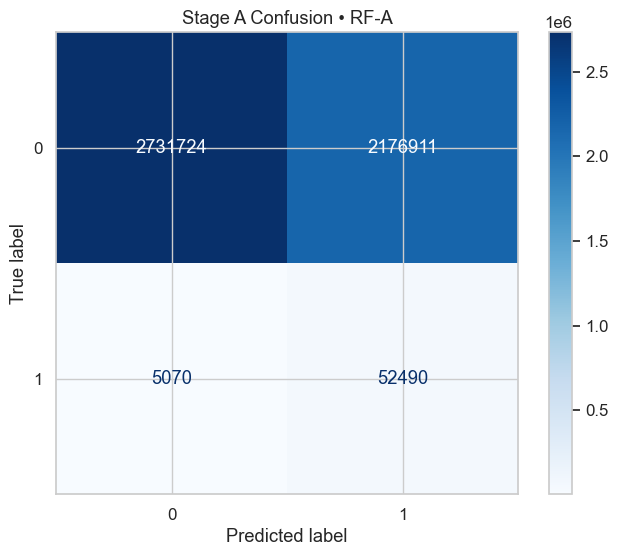

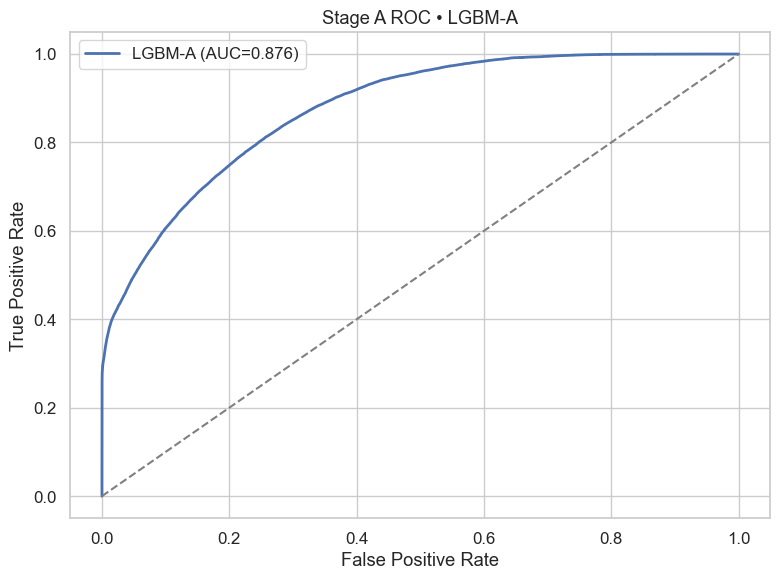

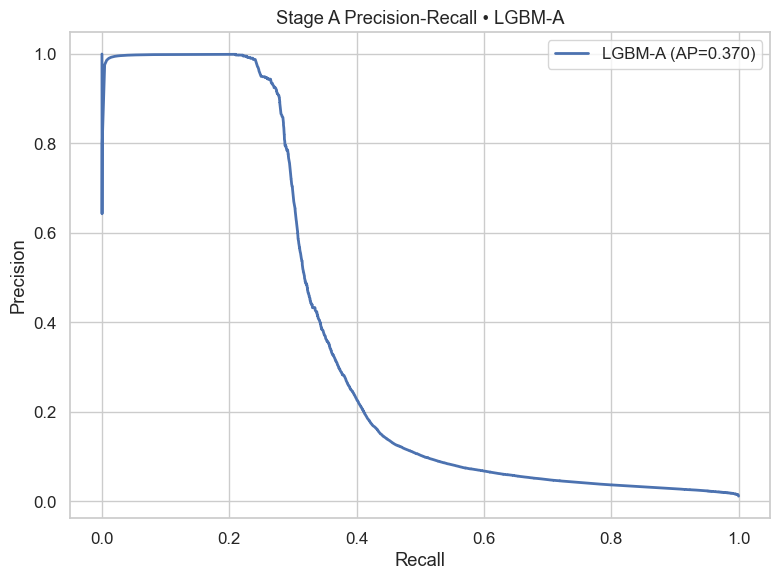

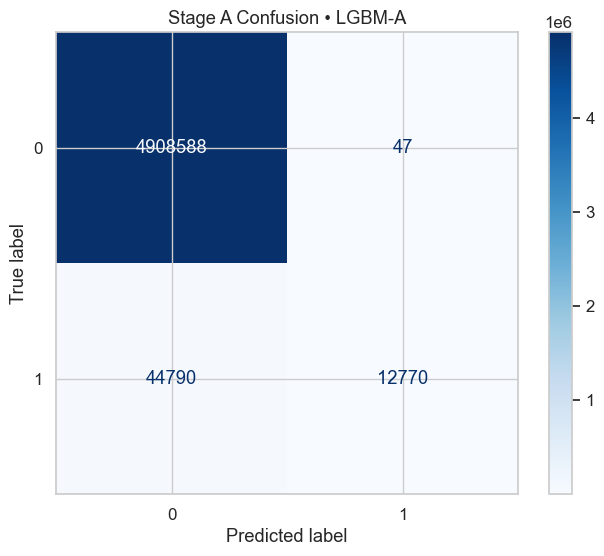

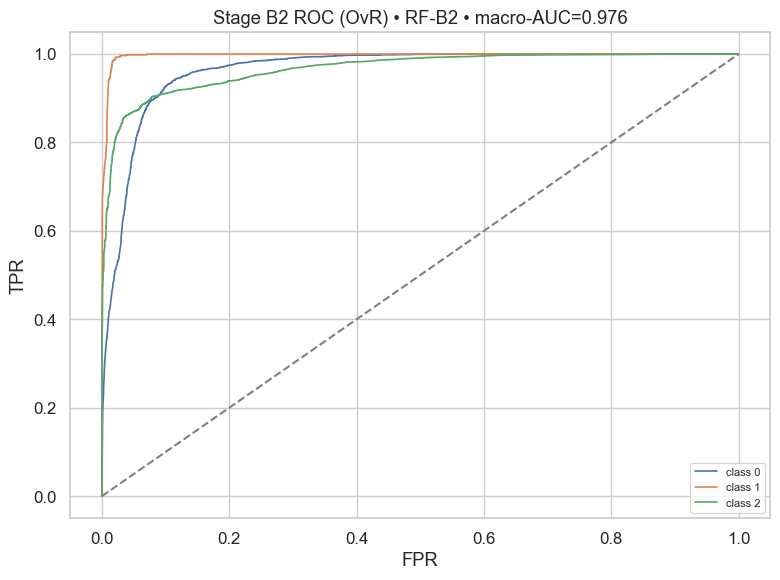

ValueError: The target y is not binary. Got multiclass type of target.

In [15]:
# ------------------------------------------------------------
# 0) Imports
# ------------------------------------------------------------
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from sklearn.metrics import (
    roc_curve, auc,
    precision_recall_curve, average_precision_score,
    confusion_matrix, ConfusionMatrixDisplay,
    classification_report
)
from sklearn.inspection import permutation_importance
from datetime import datetime
import shap                         # pip install shap if needed

# Nice global plotting style
sns.set(style="whitegrid", font_scale=1.1)
plt.rcParams["figure.figsize"] = (8,6)

# ------------------------------------------------------------
# 1) Build hold-out set  (✏️ Tweak cutoff to change its size)
# ------------------------------------------------------------


# For Stage A

y_A_hold = y_A.copy()

X_A_hold = X_A.copy()

# For Stage B2  (3-class timing model)
# your LabelEncoded targets
X_B2_hold = X_B2.copy()
y_B2_hold = y_B2.copy()

# ------------------------------------------------------------
# 2) Grab the trained models
# ------------------------------------------------------------
best_A_rf    = search_A                    # RF pipeline (already tuned)
best_A_lgbm  = search_A_lgbm.best_estimator_    # best LGBM
best_B2_rf   = search.best_estimator_           # RF
best_B2_lgbm = search_lgbm.best_estimator_      # LGBM

models_A  = {"RF-A": best_A_rf,  "LGBM-A":  best_A_lgbm}
models_B2 = {"RF-B2": best_B2_rf,"LGBM-B2": best_B2_lgbm}

# ------------------------------------------------------------
# 3) ── Stage A plots  (binary cancel / no-cancel) ────────────
# ------------------------------------------------------------
for name, model in models_A.items():
    # ------------ Predict on hold-out ------------
    proba = model.predict_proba(X_A_hold)[:,1]
    fpr, tpr, _ = roc_curve(y_A_hold, proba)
    roc_auc     = auc(fpr, tpr)
    prec, rec, _= precision_recall_curve(y_A_hold, proba)
    pr_auc      = average_precision_score(y_A_hold, proba)

    # ------------ ROC curve ------------
    plt.figure()
    plt.plot(fpr, tpr, lw=2, label=f"{name} (AUC={roc_auc:.3f})")
    plt.plot([0,1],[0,1],'--',color='grey')
    plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
    plt.title(f"Stage A ROC • {name}"); plt.legend(); plt.tight_layout()
    plt.show()

    # ------------ PR curve ------------
    plt.figure()
    plt.plot(rec, prec, lw=2, label=f"{name} (AP={pr_auc:.3f})")
    plt.xlabel("Recall"); plt.ylabel("Precision")
    plt.title(f"Stage A Precision-Recall • {name}"); plt.legend(); plt.tight_layout()
    plt.show()

    # ------------ Confusion matrix ------------
    y_pred = (proba >= 0.5).astype(int)          # default threshold-demo
    cm     = confusion_matrix(y_A_hold, y_pred)
    ConfusionMatrixDisplay(cm).plot(cmap="Blues", values_format='d')
    plt.title(f"Stage A Confusion • {name}")
    plt.show()


# ------------------------------------------------------------
# 4) ── Stage B2 plots  (multiclass timing) ───────────────────
#     Using one-vs-one ROC; macro PR; confusion.
# ------------------------------------------------------------
from sklearn.preprocessing  import label_binarize
from sklearn.metrics import roc_auc_score, PrecisionRecallDisplay

K = len(np.unique(y_B2_hold))

for name, model in models_B2.items():
    proba = model.predict_proba(X_B2_hold)        # (n, K)
    y_bin = label_binarize(y_B2_hold, classes=range(K))

    # macro-averaged ROC
    auc_ovo = roc_auc_score(y_bin, proba, average="macro", multi_class="ovo")
    plt.figure()
    for k in range(K):
        fpr, tpr, _ = roc_curve(y_bin[:,k], proba[:,k])
        plt.plot(fpr, tpr, lw=1.2, label=f"class {k}")
    plt.plot([0,1],[0,1],'--',color='grey')
    plt.title(f"Stage B2 ROC (OvR) • {name} • macro-AUC={auc_ovo:.3f}")
    plt.xlabel("FPR"); plt.ylabel("TPR"); plt.legend(fontsize=8); plt.tight_layout(); plt.show()

    # macro Precision-Recall
    disp = PrecisionRecallDisplay.from_predictions(
        y_B2_hold, proba, average="macro", name=name, plot_chance_level=True
    )
    plt.title(f"Stage B2 PR-curve • {name}")
    plt.show()

    # confusion matrix
    y_pred = proba.argmax(1)
    cm     = confusion_matrix(y_B2_hold, y_pred, labels=range(K))
    ConfusionMatrixDisplay(cm, display_labels=range(K)).plot(cmap="Purples", values_format='d')
    plt.title(f"Stage B2 Confusion • {name}")
    plt.show()




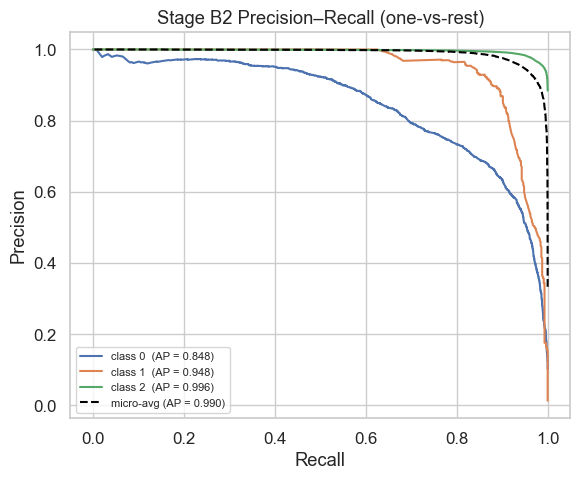

In [22]:
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import PrecisionRecallDisplay
import matplotlib.pyplot as plt
import numpy as np

y_true  = y_B2_hold                       # shape (n_samples,)
proba   = proba_B2_hold                   # shape (n_samples , K)
K       = proba.shape[1]

plt.figure(figsize=(6, 5))
for k in range(K):
    y_bin = (y_true == k).astype(int)     # 1 = “class k”, 0 = “any other”
    prec, rec, _ = precision_recall_curve(y_bin, proba[:, k])
    ap          = average_precision_score(y_bin, proba[:, k])

    plt.plot(rec, prec, lw=1.5,
             label=f"class {k}  (AP = {ap:0.3f})")

# micro-average across all one-vs-rest tasks
prec_micro, rec_micro, _ = precision_recall_curve(
    label_binarize(y_true, classes=range(K)).ravel(),
    proba.ravel()
)
ap_micro = average_precision_score(
    label_binarize(y_true, classes=range(K)),
    proba, average="micro"
)
plt.plot(rec_micro, prec_micro, color="black", ls="--",
         label=f"micro-avg (AP = {ap_micro:0.3f})")

plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("Stage B2 Precision–Recall (one-vs-rest)")
plt.legend(fontsize=8); plt.tight_layout(); plt.show()


In [ ]:
    # ------------ Feature importance ------------
    if "RF" in name:                       # permutation importance
        imp = permutation_importance(
            model, X_A_hold, y_A_hold,
            n_repeats=10, random_state=42, n_jobs=-1
        )
        imp_df = (pd.DataFrame({"feature": model.feature_names_in_,
                                "imp": imp.importances_mean})
                   .sort_values("imp", ascending=False).head(20))
        sns.barplot(data=imp_df, y="feature", x="imp", color="steelblue")
        plt.title(f"RF Stage A • Top 20 Permutation Importance")
        plt.xlabel("Mean ΔAUC"); plt.ylabel(""); plt.tight_layout(); plt.show()
    else:                                   # LGBM built-in
        imp_df = pd.DataFrame({
            "feature": model.feature_name_, 
            "gain":    model.booster_.feature_importance(importance_type="gain")
        }).sort_values("gain", ascending=False).head(20)
        sns.barplot(data=imp_df, y="feature", x="gain", color="seagreen")
        plt.title(f"LGBM Stage A • Top 20 Gain")
        plt.xlabel("Total Gain"); plt.ylabel(""); plt.tight_layout(); plt.show()

        # SHAP summary (optional, expensive)
        explainer = shap.TreeExplainer(model.booster_)
        shap_values = explainer.shap_values(X_A_hold.sample(5000, random_state=24))
        shap.summary_plot(shap_values, X_A_hold.sample(5000, random_state=24), show=False)
        plt.title(f"LGBM Stage A • SHAP Summary")
        plt.tight_layout(); plt.show()

            # Feature importance (same logic as Stage A)
    if "RF" in name:
        imp = permutation_importance(
            model, X_B2_hold, y_B2_hold,
            n_repeats=10, random_state=42, n_jobs=-1
        )
        imp_df = (pd.DataFrame({"feature": model.feature_names_in_,
                                "imp": imp.importances_mean})
                   .sort_values("imp", ascending=False).head(20))
        sns.barplot(data=imp_df, y="feature", x="imp", color="steelblue")
        plt.title(f"RF Stage B2 • Top 20 Permutation Importance")
        plt.xlabel("Mean ΔAUC"); plt.ylabel(""); plt.tight_layout(); plt.show()
    else:
        imp_df = pd.DataFrame({
            "feature": model.feature_name_, 
            "gain":    model.booster_.feature_importance(importance_type="gain")
        }).sort_values("gain", ascending=False).head(20)
        sns.barplot(data=imp_df, y="feature", x="gain", color="seagreen")
        plt.title(f"LGBM Stage B2 • Top 20 Gain")
        plt.xlabel("Total Gain"); plt.ylabel(""); plt.tight_layout(); plt.show()


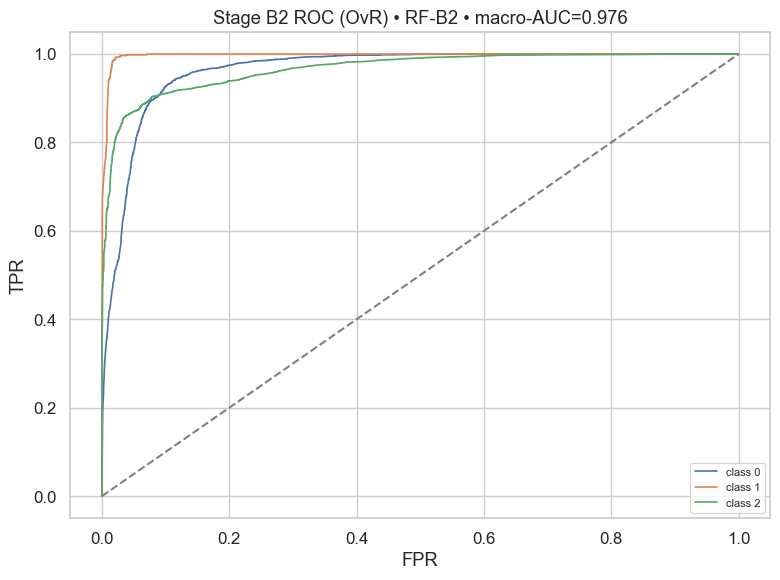

ValueError: The target y is not binary. Got multiclass type of target.

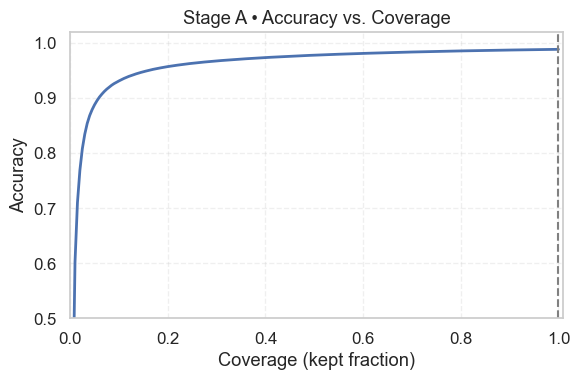

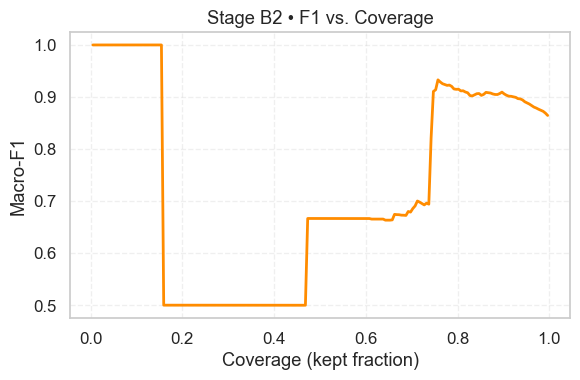

In [16]:
####ARC
import numpy as np, pandas as pd, matplotlib.pyplot as plt
# ------------------------------------------------------------
# 0) pick the best-fitted objects you already have
# ------------------------------------------------------------
best_A   = search_A_lgbm.best_estimator_        # ← Stage-A LGBM pipeline
best_B2  = search_lgbm.best_estimator_          # ← Stage-B2 LGBM pipeline

# Stage A: binary => keep the P(cancel=1) column
proba_A_hold = best_A.predict_proba(X_A_hold)[:, 1]        # shape (n_samples,)

# Stage B2: K timing buckets => keep full matrix
proba_B2_hold = best_B2.predict_proba(X_B2_hold)           # shape (n_samples, K)


def acc_reject_curve(y_true, proba, step=0.01, metric="accuracy"):
    """
    y_true : 1-d true labels      (array-like)
    proba  : 2-d predicted proba  (n_samples, n_classes)
    metric : "accuracy" | "f1_macro" | callable
    returns: DataFrame with columns [coverage , score]
    """
    from sklearn.metrics import accuracy_score, f1_score

    if isinstance(proba, pd.DataFrame): proba = proba.values
    if proba.ndim == 1: proba = proba[:, None]

    conf      = proba.max(1)          # confidence = max-prob
    order     = np.argsort(conf)[::-1]      # high-→low
    y_sorted  = np.asarray(y_true)[order]
    y_pred    = proba.argmax(1)[order]

    if metric == "accuracy":
        scorer = accuracy_score
    elif metric == "f1_macro":
        scorer = lambda yt, yp: f1_score(yt, yp, average="macro")
    elif callable(metric):
        scorer = metric
    else:
        raise ValueError("unsupported metric")

    coverages, scores = [], []
    N = len(y_true)
    for keep in range(int(step*N), N+1, int(step*N)):
        coverages.append( keep / N )
        scores.append( scorer(y_sorted[:keep], y_pred[:keep]) )

    return pd.DataFrame({"coverage":coverages, "score":scores})
# proba_A_hold already computed (see previous code) – shape (n,2)
curve_A = acc_reject_curve(y_A_hold, proba_A_hold, step=0.005)

plt.figure(figsize=(6,4))
plt.plot(curve_A.coverage, curve_A.score, lw=2, label="Selective accuracy")
plt.axvline(1.0, ls="--", color="gray")
plt.xlabel("Coverage (kept fraction)"); plt.ylabel("Accuracy")
plt.title("Stage A • Accuracy vs. Coverage")
plt.ylim(0.5,1.02); plt.xlim(0,1.01)
plt.grid(True, ls="--", alpha=.3)
plt.tight_layout(); plt.show()
# proba_B2_hold  shape (n, K)
curve_B2 = acc_reject_curve(y_B2_hold, proba_B2_hold,
                            step=0.005, metric="f1_macro")

plt.figure(figsize=(6,4))
plt.plot(curve_B2.coverage, curve_B2.score, lw=2, color="darkorange")
plt.xlabel("Coverage (kept fraction)"); plt.ylabel("Macro-F1")
plt.title("Stage B2 • F1 vs. Coverage")
plt.grid(True, ls="--", alpha=.3)
plt.tight_layout(); plt.show()


In [20]:
df_A['CanceledQty'].unique()

array([0, 1, 2])

In [34]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

models  = {"RF-B2": best_B2, "LGBM-B2": best_B2_lgbm}
n_class = len(np.unique(y_B2_hold))


for name, mdl in models.items():
    #proba = mdl.predict_proba(df_hold)
    # ① Pass through the full pipeline (no column filtering):
    #proba = mdl.predict_proba(df_hold.copy())        # mdl is the fitted pipeline

# ② – or –  Reindex to the numeric feature set the head saw during fit:
    needed = mdl.named_steps['clf'].feature_names_in_
    proba  = mdl.predict_proba(df_hold[needed].fillna(0))

    # One-vs-Rest ROC per class
    fpr, tpr, roc_auc = {}, {}, {}
    y_bin = label_binarize(y_B2_hold, classes=range(n_class))
    for k in range(n_class):
        fpr[k], tpr[k], _ = roc_curve(y_bin[:,k], proba[:,k])
        roc_auc[k] = auc(fpr[k], tpr[k])

    macro_auc = np.mean(list(roc_auc.values()))
    plt.figure(figsize=(8,6))
    for k in range(n_class):
        plt.plot(fpr[k], tpr[k],
                 label=f"class {k} (AUC={roc_auc[k]:.3f})")
    plt.plot([0,1],[0,1],"--",color="gray")
    plt.title(f"Stage B2 ROC (OvR) • {name} • macro-AUC={macro_auc:.3f}")
    plt.xlabel("FPR"); plt.ylabel("TPR"); plt.legend(); plt.tight_layout(); plt.show()

    # Macro PR-curve
    precision, recall, _ = precision_recall_curve(
        y_bin.ravel(), proba.ravel())
    ap = average_precision_score(y_bin, proba, average="macro")
    plt.figure(figsize=(8,6))
    plt.plot(recall, precision, lw=2)
    plt.title(f"Stage B2 Precision-Recall • {name} • mAP={ap:.3f}")
    plt.xlabel("Recall"); plt.ylabel("Precision"); plt.tight_layout(); plt.show()

    # Accuracy-vs-Coverage
    confid = proba.max(axis=1)                 # keep highest class prob
    sort_ix = np.argsort(confid)[::-1]         # sort by confidence
    y_sorted = y_B2_hold.iloc[sort_ix].reset_index(drop=True)
    y_pred   = proba.argmax(axis=1)[sort_ix]
    acc_curve = (y_sorted == y_pred).expanding().mean()
    coverage  = np.arange(1,len(acc_curve)+1)/len(acc_curve)

    plt.figure(figsize=(8,4))
    sns.lineplot(x=coverage, y=acc_curve)
    plt.axvline(1.0, ls="--", c="k", lw=1)
    plt.ylim(.48,1.01); plt.xlim(0,1)
    plt.title(f"Stage B2 • Accuracy vs. Coverage")
    plt.xlabel("Coverage (kept fraction)"); plt.ylabel("Accuracy"); plt.tight_layout(); plt.show()

    # Confusion-matrix
    cm = confusion_matrix(y_B2_hold, y_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=range(n_class))
    disp.plot(cmap="Blues", xticks_rotation=0, values_format="d")
    plt.title(f"Stage B2 Confusion • {name}")
    plt.tight_layout(); plt.show()


KeyError: "['Site_te', 'MenuBase_te', 'cluster_id', 'OrderQty_missing', 'MenuPrice_missing', 'MenuSubsidy_missing', 'day_of_year_missing', 'weekday_missing', 'is_weekend_missing', 'sin_doy_missing', 'cos_doy_missing', 'month_missing', 'quarter_missing', 'day_of_month_missing', 'is_month_start_missing', 'order_hour_missing', 'morning_missing', 'afternoon_missing', 'evening_missing', 'is_holiday_missing', 'tavg_C_missing', 'prcp_mm_missing', 'rain_flag_missing', 'temp_dev_missing', 'Site_te_missing', 'MenuBase_te_missing', 'hist_cancel_rate_missing', 'cluster_id_missing'] not in index"

<Figure size 800x600 with 0 Axes>

<Figure size 3850x2100 with 0 Axes>

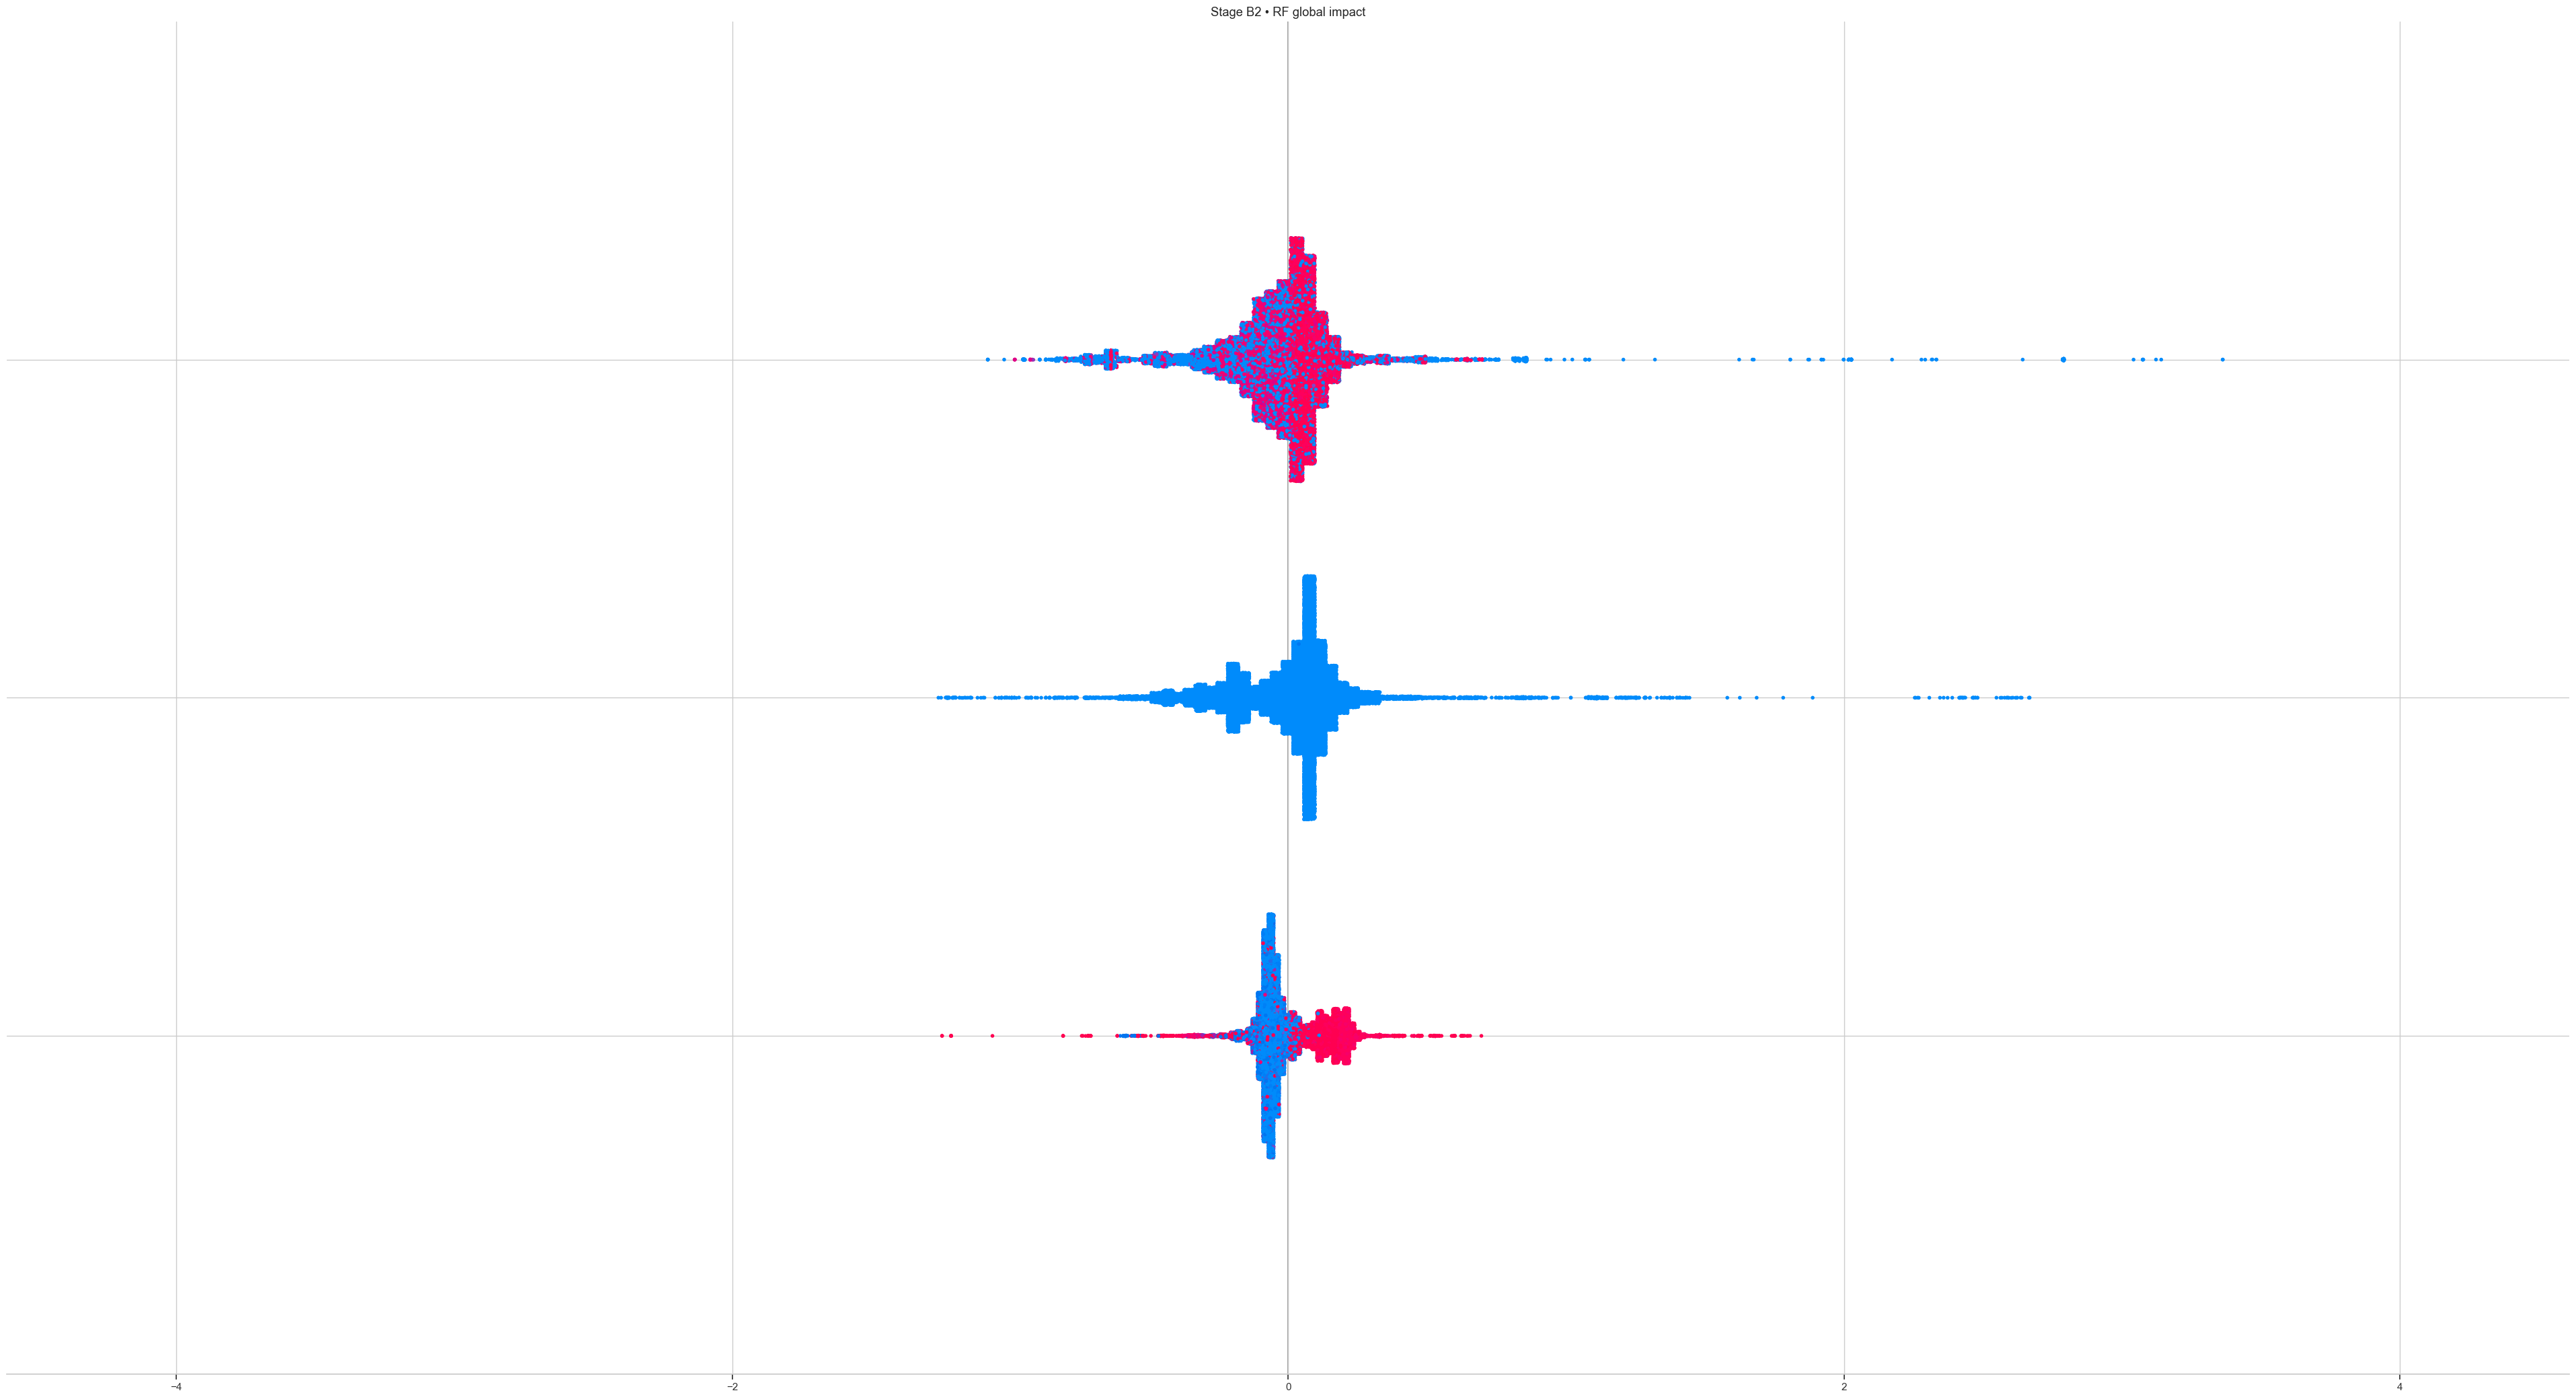

In [32]:
#########################################################
# ---- 2a) Stage A  • LGBM SHAP summary ---------------
#########################################################
import shap, pandas as pd, matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance

# pick a random 25 k sample (big data → faster)
X_sample = X_A.sample(25_000, random_state=24)
# clone best LGBM stage-A pipeline
model_A = best_A  # <- already fitted pipeline!

# SHAP expects a raw model; grab the LGBM head
lg_head = model_A.named_steps['clf']
# …and the numeric matrix produced after all transforms
X_num   = model_A[:-1].transform(X_sample)

explainer_A = shap.TreeExplainer(lg_head)
sh_values_A = explainer_A.shap_values(X_num)

shap.summary_plot(
    sh_values_A, X_num, show=False, max_display=25
)
plt.title("Stage A • LGBM global impact");               # pretty title
plt.tight_layout(); #plt.savefig("/mnt/data/shap_A_lgbm.png", dpi=250)

#########################################################
# ---- 2b) Stage B2  • RF SHAP (tree SHAP works) -------
#########################################################
X_sample_B2 = X_B2.sample(30_000, random_state=24)
model_B2 = best_B2   # fitted RF pipeline
rf_head   = model_B2.named_steps['clf']
X_num_B2  = model_B2[:-1].transform(X_sample_B2)

expl_B2 = shap.TreeExplainer(rf_head, model_output='raw')
sh_vals_B2 = expl_B2.shap_values(X_num_B2)

shap.summary_plot(
    sh_vals_B2, X_num_B2, show=False, max_display=25
)
plt.title("Stage B2 • RF global impact")
plt.tight_layout(); #plt.savefig("/mnt/data/shap_B2_rf.png", dpi=250)


In [ ]:
### Stage A for random forest with df_weather2

import numpy as np
import pandas as pd
from sklearn.base           import BaseEstimator, TransformerMixin
from sklearn.pipeline       import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.cluster       import KMeans
from sklearn.impute        import SimpleImputer
from sklearn.ensemble      import RandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from imblearn.pipeline      import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import RandomizedSearchCV


# ── 1) Prepare X / y for Stage A ────────────────────────────────
df_A    = df_train.copy()
# binary target: cancelled if CanceledQty > 0
y_A     = (df_A['CanceledQty'] > 0).astype(int)
X_A     = df_A.drop(columns=[
    'CanceledQty',      # leak
    'cancel_timing',    # multi‐class leftover
    # any other columns you know shouldn’t go in:
    'DateOfOrder','DateOfService','DateOfCancel',
    'OrderId','TransactionId','BookingNr','hist_cancel_rate','GroupName','SchoolID'
])
X_A = X_A.drop(columns=hg_vif_1)

# ── 2) Re‐use your transformers ───────────────────────────────────
class HistCancelRateTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, group_keys=('Site','MenuBase'), value_col='net_qty', out_col='hist_cancel_rate'):
        self.group_keys = group_keys
        self.value_col  = value_col
        self.out_col    = out_col
    def fit(self, X, y=None):
        keys = list(self.group_keys)
        self.hist_    = X.groupby(keys)[self.value_col].mean()
        self.default_ = self.hist_.median()
        return self
    def transform(self, X):
        keys   = list(self.group_keys)
        tuples = [tuple(r) for r in X[keys].values]
        X      = X.copy()
        X[self.out_col] = [self.hist_.get(t, self.default_) for t in tuples]
        return X

class InCVTargetEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, cols, smoothing=1.0):
        self.cols      = cols
        self.smoothing = smoothing

    def fit(self, X, y):
        self.global_mean_ = y.mean()
        self.mapping_ = {}
        for c in self.cols:
            df = pd.DataFrame({c: X[c], 'target': y})
            agg = df.groupby(c)['target'].agg(['mean','count'])
            # smoothing formula
            agg['enc'] = (
                (agg['count'] * agg['mean'] + 
                 self.smoothing * self.global_mean_)
                / (agg['count'] + self.smoothing)
            )
            self.mapping_[c] = agg['enc']
        return self

    def transform(self, X):
        X = X.copy()
        for c in self.cols:
            X[c + '_te'] = X[c]\
                .map(self.mapping_[c])\
                .fillna(self.global_mean_)
        return X

class ClusterTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, profile_feats, group_keys=('Site','MenuBase'),
                 n_clusters=5, out_col='cluster_id'):
        self.profile_feats = profile_feats
        self.group_keys    = group_keys
        self.n_clusters    = n_clusters
        self.out_col       = out_col
    def fit(self, X, y=None):
        keys = list(self.group_keys)
        prof = (X.groupby(keys)[self.profile_feats].mean().reset_index())
        prof[self.profile_feats] = prof[self.profile_feats].fillna(prof[self.profile_feats].median())
        self.scaler_ = StandardScaler().fit(prof[self.profile_feats])
        scaled      = self.scaler_.transform(prof[self.profile_feats])
        self.kmeans_ = KMeans(n_clusters=self.n_clusters, random_state=42).fit(scaled)
        tuples      = [tuple(r) for r in prof[keys].values]
        self.cluster_map_ = dict(zip(tuples, self.kmeans_.labels_))
        self.default_     = int(np.median(self.kmeans_.labels_))
        return self
    def transform(self, X):
        X = X.copy()
        keys   = list(self.group_keys)
        tuples = [tuple(r) for r in X[keys].values]
        X[self.out_col] = [self.cluster_map_.get(t, self.default_) for t in tuples]
        return X

class MissingFlagImputer(BaseEstimator, TransformerMixin):
    def __init__(self, strategy='median'):
        self.strategy = strategy
    def fit(self, X, y=None):
        self.num_cols = X.select_dtypes(include=[np.number]).columns
        clean = X[self.num_cols].replace([np.inf,-np.inf], np.nan)
        self.imputer_ = SimpleImputer(strategy=self.strategy).fit(clean)
        return self
    def transform(self, X):
        X = X.copy()
        X[self.num_cols] = X[self.num_cols].replace([np.inf,-np.inf], np.nan)
        for c in self.num_cols:
            X[c + '_missing'] = X[c].isna().astype(int)
        X[self.num_cols] = self.imputer_.transform(X[self.num_cols])
        return X

# ── 3) Drop any remaining non-numeric / ID columns ───────────────
class ColumnDropper(BaseEstimator, TransformerMixin):
    def __init__(self, cols_to_drop):
        self.cols_to_drop = cols_to_drop
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X.drop(columns=self.cols_to_drop, errors='ignore')

drop_cols_A = [
    # any string or ID cols still in X_A
    'Site','MenuBase','MenuName','GroupName','MenuNorm','MenuCode','net_qty','days_to_cancel'
]

# ── 4) Assemble Stage A pipeline ─────────────────────────────────
pipeline_A = ImbPipeline([
    #('te',      TargetEncoder(cols=['Site','MenuBase'], smoothing=0.3)),
    #('te',      InCVTargetEncoder(cols=['Site','MenuBase'], smoothing=0.3)),


    ('hist',    HistCancelRateTransformer()),
    ('cluster', ClusterTransformer(
                   profile_feats=['hist_cancel_rate','rain_flag','temp_dev','sin_doy', 'cos_doy', 'is_month_end', 'is_month_start','tavg_C', 'prcp_mm'],
                   n_clusters=9)),
    ('drop',    ColumnDropper(drop_cols_A)),
    ('impute',  MissingFlagImputer()),
    #('smote',   SMOTE(random_state=24)),
    ('clf',     RandomForestClassifier(
                   n_estimators=500,
                   criterion='entropy',     # your experiment
                   max_depth=8,
                   min_samples_split=5,
                   min_samples_leaf=1,
                   max_features='sqrt',
                   class_weight='balanced_subsample',
                   random_state=24,
                   n_jobs=-1
               )),
])

param_dist_A = {
    'clf__n_estimators':      [500],
    'clf__max_depth':         [8],
}

# 6) Rolling CV search
tscv = TimeSeriesSplit(n_splits=5)
search_A = RandomizedSearchCV(
    pipeline_A,
    param_distributions=param_dist_A,
    n_iter=30,
    cv=tscv,
    scoring='roc_auc',
    n_jobs=-1,
    random_state=24
)

search_A.fit(X_A, y_A)

print("Best LGBM ROC_AUC:", np.round(search_A.best_score_,4))
print("Best hyper‐parameters:")
for k, v in search_A.best_params_.items():
    print(f"  {k}: {v}")




/Users/sage/anaconda3/envs/pytorch_env/lib/python3.9/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 1 is smaller than n_iter=30. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best LGBM ROC_AUC: 0.7519
Best hyper‐parameters:
  clf__n_estimators: 500
  clf__max_depth: 8


In [ ]:
### without anything Stage A ROC-AUC: 0.6586
##### with hist Stage A ROC-AUC: 0.7447
### with clustering
###with clust + hist + te Stage A ROC-AUC: 0.751
###with clust 8 + hist + te Stage A ROC-AUC: 0.76


In [38]:
### stage A with df_weather2 and lgbm

import numpy as np
import pandas as pd
from sklearn.base           import BaseEstimator, TransformerMixin
from sklearn.pipeline       import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.cluster       import KMeans
from sklearn.impute        import SimpleImputer
from sklearn.ensemble      import RandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from imblearn.pipeline      import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from lightgbm import LGBMClassifier
from sklearn.model_selection import RandomizedSearchCV



# ── 1) Prepare X / y for Stage A ────────────────────────────────
df_A    = df_train.copy()
# binary target: cancelled if CanceledQty > 0
y_A     = (df_A['CanceledQty'] > 0).astype(int)
X_A     = df_A.drop(columns=[
    'CanceledQty',      # leak
    'cancel_timing',    # multi‐class leftover
    # any other columns you know shouldn’t go in:
    'DateOfOrder','DateOfService','DateOfCancel',
    'OrderId','TransactionId','BookingNr','hist_cancel_rate','GroupName','SchoolID'
])
X_A = X_A.drop(columns=hg_vif_1)


# ── 2) Re‐use your transformers ───────────────────────────────────
class HistCancelRateTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, group_keys=('Site','MenuBase'), value_col='net_qty', out_col='hist_cancel_rate'):
        self.group_keys = group_keys
        self.value_col  = value_col
        self.out_col    = out_col
    def fit(self, X, y=None):
        keys = list(self.group_keys)
        self.hist_    = X.groupby(keys)[self.value_col].mean()
        self.default_ = self.hist_.median()
        return self
    def transform(self, X):
        keys   = list(self.group_keys)
        tuples = [tuple(r) for r in X[keys].values]
        X      = X.copy()
        X[self.out_col] = [self.hist_.get(t, self.default_) for t in tuples]
        return X

class ClusterTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, profile_feats, group_keys=('Site','MenuBase'),
                 n_clusters=5, out_col='cluster_id'):
        self.profile_feats = profile_feats
        self.group_keys    = group_keys
        self.n_clusters    = n_clusters
        self.out_col       = out_col
    def fit(self, X, y=None):
        keys = list(self.group_keys)
        prof = (X.groupby(keys)[self.profile_feats].mean().reset_index())
        prof[self.profile_feats] = prof[self.profile_feats].fillna(prof[self.profile_feats].median())
        self.scaler_ = StandardScaler().fit(prof[self.profile_feats])
        scaled      = self.scaler_.transform(prof[self.profile_feats])
        self.kmeans_ = KMeans(n_clusters=self.n_clusters, random_state=42).fit(scaled)
        tuples      = [tuple(r) for r in prof[keys].values]
        self.cluster_map_ = dict(zip(tuples, self.kmeans_.labels_))
        self.default_     = int(np.median(self.kmeans_.labels_))
        return self
    def transform(self, X):
        X = X.copy()
        keys   = list(self.group_keys)
        tuples = [tuple(r) for r in X[keys].values]
        X[self.out_col] = [self.cluster_map_.get(t, self.default_) for t in tuples]
        return X

class MissingFlagImputer(BaseEstimator, TransformerMixin):
    def __init__(self, strategy='median'):
        self.strategy = strategy
    def fit(self, X, y=None):
        self.num_cols = X.select_dtypes(include=[np.number]).columns
        clean = X[self.num_cols].replace([np.inf,-np.inf], np.nan)
        self.imputer_ = SimpleImputer(strategy=self.strategy).fit(clean)
        return self
    def transform(self, X):
        X = X.copy()
        X[self.num_cols] = X[self.num_cols].replace([np.inf,-np.inf], np.nan)
        for c in self.num_cols:
            X[c + '_missing'] = X[c].isna().astype(int)
        X[self.num_cols] = self.imputer_.transform(X[self.num_cols])
        return X

# ── 3) Drop any remaining non-numeric / ID columns ───────────────
class ColumnDropper(BaseEstimator, TransformerMixin):
    def __init__(self, cols_to_drop):
        self.cols_to_drop = cols_to_drop
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X.drop(columns=self.cols_to_drop, errors='ignore')

drop_cols_A = [
    # any string or ID cols still in X_A
    'Site','MenuBase','MenuName','GroupName','MenuNorm','MenuCode','net_qty','days_to_cancel'
]

# ── 4) Assemble Stage A pipeline ─────────────────────────────────
pipeline_A_l = ImbPipeline([
    #('te',      TargetEncoder(cols=['Site','MenuBase'], smoothing=0.3)),
    ('te',      InCVTargetEncoder(cols=['Site','MenuBase'], smoothing=0.3)),


    ('hist',    HistCancelRateTransformer()),
    ('cluster', ClusterTransformer(
                   profile_feats=['hist_cancel_rate','rain_flag','temp_dev','sin_doy', 'cos_doy', 'is_month_end', 'is_month_start','tavg_C', 'prcp_mm'],
                   n_clusters=8)),
    ('drop',    ColumnDropper(drop_cols_A)),
    ('impute',  MissingFlagImputer()),
    #('smote',   SMOTE(random_state=24)),
    ('clf',       LGBMClassifier(objective='multiclass',
                                 num_class=len(np.unique(y_A)),
                                 random_state=24,
                                 metric    = "multi_logloss",
                                 n_jobs=-1))
,
])
param_dist_lgbm = {
    'clf__n_estimators':      [500],
    'clf__learning_rate':     [0.01],
    'clf__num_leaves':        [31],
    'clf__max_depth':         [10],
    'clf__subsample':         [0.7],
    'clf__colsample_bytree':  [1.0],
    'clf__min_child_samples': [10]
}

# 6) Rolling CV search
tscv = TimeSeriesSplit(n_splits=5)
search_A_lgbm = RandomizedSearchCV(
    pipeline_A_l,
    param_distributions=param_dist_lgbm,
    n_iter=30,
    cv=tscv,
    scoring='balanced_accuracy',
    n_jobs=-1,
    random_state=24
)

search_A_lgbm.fit(X_A, y_A)

print("Best LGBM BA:", np.round(search_A_lgbm.best_score_,4))
print("Best hyper‐parameters:")
for k, v in search_A_lgbm.best_params_.items():
    print(f"  {k}: {v}")



/Users/sage/anaconda3/envs/pytorch_env/lib/python3.9/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 1 is smaller than n_iter=30. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.027620 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1090
[LightGBM] [Info] Number of data points in the train set: 827700, number of used features: 19
[LightGBM] [Info] Start training from score -0.010747
[LightGBM] [Info] Start training from score -4.538459
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.054384 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1158
[LightGBM] [Info] Number of data points in the train set: 1655399, number of used features: 19
[LightGBM] [Info] Start training from score -0.010804
[LightGBM] [Info] Start training from score -4.533217
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of t

In [ ]:
#Best LGBM ROC_AUC: 0.6738
## with hist LGBM ROC_AUC: 0.7428
## LGBM ROC with cluster LGBM ROC_AUC: 0.7435
## with target encoding LGBM ROC_AUC: 0.75
### after hyperparameters- 



['evening',
 'morning',
 'afternoon',
 'day_of_year',
 'month',
 'day_of_month',
 'quarter']

sin_doy                     2.541828e+06
hist_cancel_rate            1.808337e+06
order_hour                  1.524046e+06
tavg_C                      1.432176e+06
MenuBase_te                 8.869563e+05
MenuSubsidy                 4.883934e+05
temp_dev                    4.084264e+05
MenuPrice                   3.747314e+05
prcp_mm                     2.661320e+05
weekday                     1.625708e+05
Site_te                     8.829139e+04
cos_doy                     6.932392e+04
is_month_start              1.291177e+04
cluster_id                  6.290340e+03
is_month_end                1.854155e+03
is_weekend                  1.320444e+02
is_holiday                  4.376080e+01
prcp_mm_missing             0.000000e+00
OrderQty                    0.000000e+00
tavg_C_missing              0.000000e+00
temp_dev_missing            0.000000e+00
rain_flag_missing           0.000000e+00
hist_cancel_rate_missing    0.000000e+00
Site_te_missing             0.000000e+00
MenuBase_te_miss

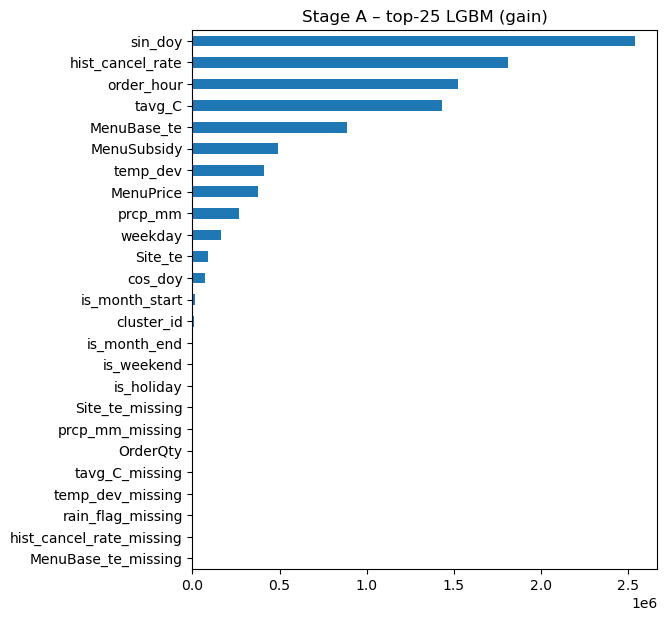

In [30]:
#### feature imp
import pandas as pd

best_A  = search_A_lgbm.best_estimator_
lgbm    = best_A.named_steps['clf']              # LGBMClassifier

# LightGBM offers several types; “gain” is the most stable
gain = lgbm.booster_.feature_importance(importance_type='gain')
feat = lgbm.booster_.feature_name()

imp_lgbm = (
    pd.Series(gain, index=feat)
      .sort_values(ascending=False)
)

print(imp_lgbm.head(25))
imp_lgbm.head(25).sort_values().plot(kind='barh', figsize=(6,7),
                                     title='Stage A – top-25 LGBM (gain)');



In [9]:
#### stage B2 with hist_cancel_rate and cluster calculation inside the cv loop and target encoding
from sklearn.base           import BaseEstimator, TransformerMixin
from sklearn.pipeline       import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.cluster       import KMeans
from sklearn.impute        import SimpleImputer
from sklearn.ensemble      import RandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
import numpy as np
from sklearn.preprocessing import LabelEncoder
from category_encoders import TargetEncoder



df_B2 = df_train[df_train.cancel_timing != 'no_cancel'].copy()
le    = LabelEncoder().fit(df_B2.cancel_timing)
df_B2['timing_code'] = le.transform(df_B2.cancel_timing)

# drop any leak columns before X
X_B2 = df_B2.drop(columns=[
    'CanceledQty',      
    'cancel_timing','timing_code',     
    'DateOfOrder','DateOfService','DateOfCancel',
    'OrderId','TransactionId','BookingNr','hist_cancel_rate','GroupName','SchoolID','is_month_end'
])
y_B2 = df_B2['timing_code']
# 0) Build the Stage B2 subset once:
#df_B2 = df_weather[
#    (df_weather.CanceledQty > 0) &
#    (df_weather.cancel_timing.isin([0,1,2]))
#].copy()
#X_full = df_B2.drop(columns='cancel_timing')
#y_full = df_B2['cancel_timing']

# Update to HistCancelRateTransformer and ClusterTransformer to avoid tuple KeyError

import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

class InCVTargetEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, cols, smoothing=1.0):
        self.cols      = cols
        self.smoothing = smoothing

    def fit(self, X, y):
        self.global_mean_ = y.mean()
        self.mapping_ = {}
        for c in self.cols:
            df = pd.DataFrame({c: X[c], 'target': y})
            agg = df.groupby(c)['target'].agg(['mean','count'])
            # smoothing formula
            agg['enc'] = (
                (agg['count'] * agg['mean'] + 
                 self.smoothing * self.global_mean_)
                / (agg['count'] + self.smoothing)
            )
            self.mapping_[c] = agg['enc']
        return self

    def transform(self, X):
        X = X.copy()
        for c in self.cols:
            X[c + '_te'] = X[c]\
                .map(self.mapping_[c])\
                .fillna(self.global_mean_)
        return X



class HistCancelRateTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, group_keys=('Site','MenuBase'), value_col='net_qty', out_col='hist_cancel_rate'):
        # Store parameters verbatim—do NOT convert to list here
        self.group_keys = group_keys
        self.value_col  = value_col
        self.out_col    = out_col
        
    def fit(self, X, y=None):
        # Convert to list only when you need it
        keys = list(self.group_keys)
        self.hist_    = X.groupby(keys)[self.value_col].mean()
        self.default_ = self.hist_.median()
        return self
    
    def transform(self, X):
        keys = list(self.group_keys)
        # build tuple keys and map
        tuples = list(zip(*(X[k] for k in keys)))
        X = X.copy()
        X[self.out_col] = [self.hist_.get(t, self.default_) for t in tuples]
        return X


from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import numpy as np

class ClusterTransformer(BaseEstimator, TransformerMixin):
    def __init__(
        self,
        profile_feats,                 # list of column names to form profiles
        group_keys=('Site','MenuBase'),
        n_clusters=5,
        out_col='cluster_id'
    ):
        # Store parameters as‐is; don’t mutate them here
        self.profile_feats = profile_feats
        self.group_keys    = group_keys
        self.n_clusters    = n_clusters
        self.out_col       = out_col

    def fit(self, X, y=None):
        # 1) Build training set profiles by group
        keys = list(self.group_keys)
        prof = (
            X.groupby(keys)[self.profile_feats]
             .mean()
             .reset_index()
        )
        # 2) Median‐impute any missing values in the profiles
        prof[self.profile_feats] = prof[self.profile_feats].fillna(
            prof[self.profile_feats].median()
        )

        # 3) Standardize and run K-Means on those profiles
        self.scaler_ = StandardScaler().fit(prof[self.profile_feats])
        scaled      = self.scaler_.transform(prof[self.profile_feats])
        self.kmeans_ = KMeans(n_clusters=self.n_clusters, random_state=42).fit(scaled)

        # 4) Build a lookup map from (Site,MenuBase) → cluster label
        tuples = [tuple(row) for row in prof[keys].values]
        labels = list(self.kmeans_.labels_)
        self.cluster_map_ = dict(zip(tuples, labels))
        # Use the median cluster as a fallback for unseen combos
        self.default_ = int(np.median(labels))
        return self

    def transform(self, X):
        X = X.copy()
        keys   = list(self.group_keys)
        tuples = [tuple(row) for row in X[keys].values]
        # Map each row’s key to its cluster (or default)
        X[self.out_col] = [
            self.cluster_map_.get(t, self.default_) for t in tuples
        ]
        return X



class MissingFlagImputer(BaseEstimator, TransformerMixin):
    def __init__(self, strategy='median'):
        self.strategy = strategy

    def fit(self, X, y=None):
        # Identify numeric columns
        self.num_cols = X.select_dtypes(include=[np.number]).columns
        # Replace inf with NaN for fitting
        clean = X[self.num_cols].replace([np.inf, -np.inf], np.nan)
        # Fit the imputer on cleaned data
        self.imputer_ = SimpleImputer(strategy=self.strategy)
        self.imputer_.fit(clean)
        return self

    def transform(self, X):
        X = X.copy()
        # Replace inf with NaN before transforming
        X[self.num_cols] = X[self.num_cols].replace([np.inf, -np.inf], np.nan)
        # Add missing flags
        for c in self.num_cols:
            X[c + '_missing'] = X[c].isna().astype(int)
        # Impute
        X[self.num_cols] = self.imputer_.transform(X[self.num_cols])
        return X

# Example integration into your pipeline:
# pipeline_B2 = Pipeline([
#     ('hist', HistCancelRateTransformer()),
#     ('cluster', ClusterTransformer(...)),
#     ('impute', MissingFlagImputer()),
#     ('clf', RandomForestClassifier(...))
# ])

# 4) Assemble pipelin
from sklearn.base import BaseEstimator, TransformerMixin

class ColumnDropper(BaseEstimator, TransformerMixin):
    def __init__(self, cols_to_drop):
        self.cols_to_drop = cols_to_drop

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # Drop any columns we know are non-numeric, IDs, or leftovers
        return X.drop(columns=self.cols_to_drop,errors='ignore')
drop_cols_B2 = [
    'MenuName','GroupName','MenuNorm','MenuCode'

]
drop_post = ['Site','MenuBase','net_qty','days_to_cancel']
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
# 4) Assemble pipelin

#pipeline_B2 = Pipeline([
#    ('drop',    ColumnDropper(drop_cols_B2)),
#    ('hist',    HistCancelRateTransformer()),         # train-only hist rates
#    ('cluster', ClusterTransformer(
#                   profile_feats=['hist_cancel_rate','rain_flag','temp_dev'],
#                   n_clusters=5)),
#    ('impute',  MissingFlagImputer()),               # replace inf → NaN, flag + median
#    ('clf',     RandomForestClassifier(
#                   n_estimators=100,
#                   class_weight='balanced',
#                   random_state=24,
#                   n_jobs=-1
#               )),
#])

#print("Columns going into the pipeline:", X_full.columns.tolist())
pipeline_B2_smote = ImbPipeline([
    ('te',      InCVTargetEncoder(cols=['Site','MenuBase'], smoothing=0.3)),
    ('drop',    ColumnDropper(drop_cols_B2)),                # drop strings, IDs, leakage cols
    ('hist',    HistCancelRateTransformer()),                # train‐only hist rates
    ('cluster', ClusterTransformer(                          # train‐only clusters
                   profile_feats=['hist_cancel_rate','rain_flag','temp_dev','sin_doy', 'cos_doy', 'is_month_start','tavg_C', 'prcp_mm'],
                    n_clusters=8)),
    ('drop_post', ColumnDropper(drop_post)),               
    ('impute',  MissingFlagImputer()),                       # inf→nan, flag & median‐impute
    #('smote',   SMOTE(random_state=24)),                     # synthesize new minority samples
    ('clf',     RandomForestClassifier(                      # your tuned RF head
                   n_estimators=500,
                   min_samples_split=5,
                   min_samples_leaf=2,
                   max_features='sqrt',
                   max_depth=None,
                   class_weight='balanced',
                   random_state=24,
                   n_jobs=-1
               )),
])
# 5) Rolling CV evaluation
tscv    = TimeSeriesSplit(n_splits=5)
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
import numpy as np

# 1) Define the time‐series split
#tscv = TimeSeriesSplit(n_splits=5)

# 2) Specify the RF hyper‐parameter distributions
param_dist = {
    'clf__n_estimators':      [600],
    'clf__max_depth':         [10],
    'clf__min_samples_split': [10],
    'clf__min_samples_leaf':  [15],
    'clf__bootstrap':         [True],
    'clf__criterion':         ['entropy'],
    'clf__max_features':      [0.8]
}

search = RandomizedSearchCV(
    pipeline_B2_smote,               # the full hist→cluster→impute→RF pipe
    param_distributions=param_dist,
    n_iter=20,                 # how many random combos to try
    cv=tscv,                   # your time‐series folds
    scoring='roc_auc_ovo_weighted',  # optimize roc_auc_ovo_weighted
    n_jobs=-1,
    random_state=24
)

# 4) Fit on your Stage B2 data
search.fit(X_B2, y_B2)

# 5) Check the results
print("Best roc_auc_ovo_weighted:", np.round(search.best_score_, 4))
print("Best hyper-parameters:")
for k, v in search.best_params_.items():
    print(f"  {k} = {v}")
#scores  = cross_val_score(
#    pipeline_B2,
#    X_full,
#    y_full,
#    cv=tscv,
#    scoring='average_precision',
#    n_jobs=1
#)
#print("Stage B2 PR-AUC:", np.round(scores.mean(),4))


/Users/sage/anaconda3/envs/pytorch_env/lib/python3.9/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 1 is smaller than n_iter=20. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best roc_auc_ovo_weighted: 0.6893
Best hyper-parameters:
  clf__n_estimators = 600
  clf__min_samples_split = 10
  clf__min_samples_leaf = 15
  clf__max_features = 0.8
  clf__max_depth = 10
  clf__criterion = entropy
  clf__bootstrap = True


In [ ]:
### without hist,clus, roc_auc_ovo_weighted: 0.6781
###with all roc_auc_ovo_weighted: 0.6893


In [10]:
#### stage B2 with hist_cancel_rate and cluster calculation inside the cv loop and target encoding LGBM
from sklearn.base           import BaseEstimator, TransformerMixin
from sklearn.pipeline       import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.cluster       import KMeans
from sklearn.impute        import SimpleImputer
from sklearn.ensemble      import RandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
import numpy as np
from sklearn.preprocessing import LabelEncoder
from category_encoders import TargetEncoder
from lightgbm import LGBMClassifier




df_B2 = df_train[df_train.cancel_timing != 'no_cancel'].copy()
le    = LabelEncoder().fit(df_B2.cancel_timing)
df_B2['timing_code'] = le.transform(df_B2.cancel_timing)

# drop any leak columns before X
X_B2 = df_B2.drop(columns=[
    'CanceledQty',      
    'cancel_timing','timing_code',     
    'DateOfOrder','DateOfService','DateOfCancel',
    'OrderId','TransactionId','BookingNr','hist_cancel_rate','GroupName','SchoolID','is_month_end'
])
y_B2 = df_B2['timing_code']
# 0) Build the Stage B2 subset once:
#df_B2 = df_weather[
#    (df_weather.CanceledQty > 0) &
#    (df_weather.cancel_timing.isin([0,1,2]))
#].copy()
#X_full = df_B2.drop(columns='cancel_timing')
#y_full = df_B2['cancel_timing']

# Update to HistCancelRateTransformer and ClusterTransformer to avoid tuple KeyError

import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

class InCVTargetEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, cols, smoothing=1.0):
        self.cols      = cols
        self.smoothing = smoothing

    def fit(self, X, y):
        self.global_mean_ = y.mean()
        self.mapping_ = {}
        for c in self.cols:
            df = pd.DataFrame({c: X[c], 'target': y})
            agg = df.groupby(c)['target'].agg(['mean','count'])
            # smoothing formula
            agg['enc'] = (
                (agg['count'] * agg['mean'] + 
                 self.smoothing * self.global_mean_)
                / (agg['count'] + self.smoothing)
            )
            self.mapping_[c] = agg['enc']
        return self

    def transform(self, X):
        X = X.copy()
        for c in self.cols:
            X[c + '_te'] = X[c]\
                .map(self.mapping_[c])\
                .fillna(self.global_mean_)
        return X



class HistCancelRateTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, group_keys=('Site','MenuBase'), value_col='net_qty', out_col='hist_cancel_rate'):
        # Store parameters verbatim—do NOT convert to list here
        self.group_keys = group_keys
        self.value_col  = value_col
        self.out_col    = out_col
        
    def fit(self, X, y=None):
        # Convert to list only when you need it
        keys = list(self.group_keys)
        self.hist_    = X.groupby(keys)[self.value_col].mean()
        self.default_ = self.hist_.median()
        return self
    
    def transform(self, X):
        keys = list(self.group_keys)
        # build tuple keys and map
        tuples = list(zip(*(X[k] for k in keys)))
        X = X.copy()
        X[self.out_col] = [self.hist_.get(t, self.default_) for t in tuples]
        return X


from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import numpy as np

class ClusterTransformer(BaseEstimator, TransformerMixin):
    def __init__(
        self,
        profile_feats,                 # list of column names to form profiles
        group_keys=('Site','MenuBase'),
        n_clusters=5,
        out_col='cluster_id'
    ):
        # Store parameters as‐is; don’t mutate them here
        self.profile_feats = profile_feats
        self.group_keys    = group_keys
        self.n_clusters    = n_clusters
        self.out_col       = out_col

    def fit(self, X, y=None):
        # 1) Build training set profiles by group
        keys = list(self.group_keys)
        prof = (
            X.groupby(keys)[self.profile_feats]
             .mean()
             .reset_index()
        )
        # 2) Median‐impute any missing values in the profiles
        prof[self.profile_feats] = prof[self.profile_feats].fillna(
            prof[self.profile_feats].median()
        )

        # 3) Standardize and run K-Means on those profiles
        self.scaler_ = StandardScaler().fit(prof[self.profile_feats])
        scaled      = self.scaler_.transform(prof[self.profile_feats])
        self.kmeans_ = KMeans(n_clusters=self.n_clusters, random_state=42).fit(scaled)

        # 4) Build a lookup map from (Site,MenuBase) → cluster label
        tuples = [tuple(row) for row in prof[keys].values]
        labels = list(self.kmeans_.labels_)
        self.cluster_map_ = dict(zip(tuples, labels))
        # Use the median cluster as a fallback for unseen combos
        self.default_ = int(np.median(labels))
        return self

    def transform(self, X):
        X = X.copy()
        keys   = list(self.group_keys)
        tuples = [tuple(row) for row in X[keys].values]
        # Map each row’s key to its cluster (or default)
        X[self.out_col] = [
            self.cluster_map_.get(t, self.default_) for t in tuples
        ]
        return X



class MissingFlagImputer(BaseEstimator, TransformerMixin):
    def __init__(self, strategy='median'):
        self.strategy = strategy

    def fit(self, X, y=None):
        # Identify numeric columns
        self.num_cols = X.select_dtypes(include=[np.number]).columns
        # Replace inf with NaN for fitting
        clean = X[self.num_cols].replace([np.inf, -np.inf], np.nan)
        # Fit the imputer on cleaned data
        self.imputer_ = SimpleImputer(strategy=self.strategy)
        self.imputer_.fit(clean)
        return self

    def transform(self, X):
        X = X.copy()
        # Replace inf with NaN before transforming
        X[self.num_cols] = X[self.num_cols].replace([np.inf, -np.inf], np.nan)
        # Add missing flags
        for c in self.num_cols:
            X[c + '_missing'] = X[c].isna().astype(int)
        # Impute
        X[self.num_cols] = self.imputer_.transform(X[self.num_cols])
        return X

# Example integration into your pipeline:
# pipeline_B2 = Pipeline([
#     ('hist', HistCancelRateTransformer()),
#     ('cluster', ClusterTransformer(...)),
#     ('impute', MissingFlagImputer()),
#     ('clf', RandomForestClassifier(...))
# ])

# 4) Assemble pipelin
from sklearn.base import BaseEstimator, TransformerMixin

class ColumnDropper(BaseEstimator, TransformerMixin):
    def __init__(self, cols_to_drop):
        self.cols_to_drop = cols_to_drop

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # Drop any columns we know are non-numeric, IDs, or leftovers
        return X.drop(columns=self.cols_to_drop,errors='ignore')
drop_cols_B2 = [
    'MenuName','GroupName','MenuNorm','MenuCode'

]
drop_post = ['Site','MenuBase','net_qty','days_to_cancel']
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
# 4) Assemble pipelin

#pipeline_B2 = Pipeline([
#    ('drop',    ColumnDropper(drop_cols_B2)),
#    ('hist',    HistCancelRateTransformer()),         # train-only hist rates
#    ('cluster', ClusterTransformer(
#                   profile_feats=['hist_cancel_rate','rain_flag','temp_dev'],
#                   n_clusters=5)),
#    ('impute',  MissingFlagImputer()),               # replace inf → NaN, flag + median
#    ('clf',     RandomForestClassifier(
#                   n_estimators=100,
#                   class_weight='balanced',
#                   random_state=24,
#                   n_jobs=-1
#               )),
#])

#print("Columns going into the pipeline:", X_full.columns.tolist())
pipeline_B2_lgbm = ImbPipeline([
    ('te',      InCVTargetEncoder(cols=['Site','MenuBase'], smoothing=0.3)),
    ('drop',    ColumnDropper(drop_cols_B2)),                # drop strings, IDs, leakage cols
    ('hist',    HistCancelRateTransformer()),                # train‐only hist rates
    ('cluster', ClusterTransformer(                          # train‐only clusters
                    profile_feats=['hist_cancel_rate','rain_flag','temp_dev','sin_doy', 'cos_doy', 'is_month_start','tavg_C', 'prcp_mm'],
                    n_clusters=8)),
    ('drop_post', ColumnDropper(drop_post)),               
    ('impute',  MissingFlagImputer()),                       # inf→nan, flag & median‐impute
    #('smote',   SMOTE(random_state=24)),                     # synthesize new minority samples
   ('clf',       LGBMClassifier(objective='multiclass',
                                 num_class=len(np.unique(y_B2)),
                                 random_state=24,
                                 metric    = "multi_logloss",
                                 n_jobs=-1))
,
])
param_dist_lgbm = {
    'clf__n_estimators':      [500],
    'clf__learning_rate':     [0.01],
    'clf__num_leaves':        [31],
    'clf__max_depth':         [10],
    'clf__subsample':         [0.7],
    'clf__colsample_bytree':  [1.0],
    'clf__min_child_samples': [20]
}

# 6) Rolling CV search
tscv = TimeSeriesSplit(n_splits=5)
search_lgbm = RandomizedSearchCV(
    pipeline_B2_lgbm,
    param_distributions=param_dist_lgbm,
    n_iter=30,
    cv=tscv,
    scoring='roc_auc_ovo_weighted',
    n_jobs=-1,
    random_state=24
)

search_lgbm.fit(X_B2, y_B2)

print("Best LGBM ROC_AUC_OVO_weighted:", np.round(search_lgbm.best_score_,4))
print("Best hyper‐parameters:")
for k, v in search_lgbm.best_params_.items():
    print(f"  {k}: {v}")


/Users/sage/anaconda3/envs/pytorch_env/lib/python3.9/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 1 is smaller than n_iter=30. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001785 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 960
[LightGBM] [Info] Number of data points in the train set: 14652, number of used features: 21
[LightGBM] [Info] Start training from score -2.313013
[LightGBM] [Info] Start training from score -4.756050
[LightGBM] [Info] Start training from score -0.113798
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001843 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1091
[LightGBM] [Info] Number of data points in the train set: 21977, number of used features: 22
[LightGBM] [Info] Start training from score -2.404378
[LightGBM] [Info] Start training from score -5.085097
[LightGBM] [Info] Start t

In [ ]:
####without hist, cluster,te LGBM ROC_AUC_OVO_weighted: 0.6692
###with LGBM ROC_AUC_OVO_weighted: 0.74


In [ ]:
#### stage B2 with hist_cancel_rate and cluster calculation inside the cv loop and target encoding catboost
from sklearn.base           import BaseEstimator, TransformerMixin
from sklearn.pipeline       import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.cluster       import KMeans
from sklearn.impute        import SimpleImputer
from sklearn.ensemble      import RandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
import numpy as np
from sklearn.preprocessing import LabelEncoder
from category_encoders import TargetEncoder
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.metrics import make_scorer, f1_score, balanced_accuracy_score




df_B2 = df_weather2[df_weather2.cancel_timing != 'no_cancel'].copy()
le    = LabelEncoder().fit(df_B2.cancel_timing)
df_B2['timing_code'] = le.transform(df_B2.cancel_timing)

# drop any leak columns before X
X_B2 = df_B2.drop(columns=[
    'CanceledQty',      
    'cancel_timing','timing_code',     
    'DateOfOrder','DateOfService','DateOfCancel',
    'OrderId','TransactionId','BookingNr','hist_cancel_rate','GroupName','SchoolID'
])
#y_B2 = df_B2['timing_code']
y_B2 = df_B2['net_qty']
# 0) Build the Stage B2 subset once:
#df_B2 = df_weather[
#    (df_weather.CanceledQty > 0) &
#    (df_weather.cancel_timing.isin([0,1,2]))
#].copy()
#X_full = df_B2.drop(columns='cancel_timing')
#y_full = df_B2['cancel_timing']

# Update to HistCancelRateTransformer and ClusterTransformer to avoid tuple KeyError

import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

class InCVTargetEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, cols, smoothing=1.0):
        self.cols      = cols
        self.smoothing = smoothing

    def fit(self, X, y):
        self.global_mean_ = y.mean()
        self.mapping_ = {}
        for c in self.cols:
            df = pd.DataFrame({c: X[c], 'target': y})
            agg = df.groupby(c)['target'].agg(['mean','count'])
            # smoothing formula
            agg['enc'] = (
                (agg['count'] * agg['mean'] + 
                 self.smoothing * self.global_mean_)
                / (agg['count'] + self.smoothing)
            )
            self.mapping_[c] = agg['enc']
        return self

    def transform(self, X):
        X = X.copy()
        for c in self.cols:
            X[c + '_te'] = X[c]\
                .map(self.mapping_[c])\
                .fillna(self.global_mean_)
        return X



class HistCancelRateTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, group_keys=('Site','MenuBase'), value_col='net_qty', out_col='hist_cancel_rate'):
        # Store parameters verbatim—do NOT convert to list here
        self.group_keys = group_keys
        self.value_col  = value_col
        self.out_col    = out_col
        
    def fit(self, X, y=None):
        # Convert to list only when you need it
        keys = list(self.group_keys)
        self.hist_    = X.groupby(keys)[self.value_col].mean()
        self.default_ = self.hist_.median()
        return self
    
    def transform(self, X):
        keys = list(self.group_keys)
        # build tuple keys and map
        tuples = list(zip(*(X[k] for k in keys)))
        X = X.copy()
        X[self.out_col] = [self.hist_.get(t, self.default_) for t in tuples]
        return X


from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import numpy as np

class ClusterTransformer(BaseEstimator, TransformerMixin):
    def __init__(
        self,
        profile_feats,                 # list of column names to form profiles
        group_keys=('Site','MenuBase'),
        n_clusters=5,
        out_col='cluster_id'
    ):
        # Store parameters as‐is; don’t mutate them here
        self.profile_feats = profile_feats
        self.group_keys    = group_keys
        self.n_clusters    = n_clusters
        self.out_col       = out_col

    def fit(self, X, y=None):
        # 1) Build training set profiles by group
        keys = list(self.group_keys)
        prof = (
            X.groupby(keys)[self.profile_feats]
             .mean()
             .reset_index()
        )
        # 2) Median‐impute any missing values in the profiles
        prof[self.profile_feats] = prof[self.profile_feats].fillna(
            prof[self.profile_feats].median()
        )

        # 3) Standardize and run K-Means on those profiles
        self.scaler_ = StandardScaler().fit(prof[self.profile_feats])
        scaled      = self.scaler_.transform(prof[self.profile_feats])
        self.kmeans_ = KMeans(n_clusters=self.n_clusters, random_state=42).fit(scaled)

        # 4) Build a lookup map from (Site,MenuBase) → cluster label
        tuples = [tuple(row) for row in prof[keys].values]
        labels = list(self.kmeans_.labels_)
        self.cluster_map_ = dict(zip(tuples, labels))
        # Use the median cluster as a fallback for unseen combos
        self.default_ = int(np.median(labels))
        return self

    def transform(self, X):
        X = X.copy()
        keys   = list(self.group_keys)
        tuples = [tuple(row) for row in X[keys].values]
        # Map each row’s key to its cluster (or default)
        X[self.out_col] = [
            self.cluster_map_.get(t, self.default_) for t in tuples
        ]
        return X



class MissingFlagImputer(BaseEstimator, TransformerMixin):
    def __init__(self, strategy='median'):
        self.strategy = strategy

    def fit(self, X, y=None):
        # Identify numeric columns
        self.num_cols = X.select_dtypes(include=[np.number]).columns
        # Replace inf with NaN for fitting
        clean = X[self.num_cols].replace([np.inf, -np.inf], np.nan)
        # Fit the imputer on cleaned data
        self.imputer_ = SimpleImputer(strategy=self.strategy)
        self.imputer_.fit(clean)
        return self

    def transform(self, X):
        X = X.copy()
        # Replace inf with NaN before transforming
        X[self.num_cols] = X[self.num_cols].replace([np.inf, -np.inf], np.nan)
        # Add missing flags
        for c in self.num_cols:
            X[c + '_missing'] = X[c].isna().astype(int)
        # Impute
        X[self.num_cols] = self.imputer_.transform(X[self.num_cols])
        return X

# Example integration into your pipeline:
# pipeline_B2 = Pipeline([
#     ('hist', HistCancelRateTransformer()),
#     ('cluster', ClusterTransformer(...)),
#     ('impute', MissingFlagImputer()),
#     ('clf', RandomForestClassifier(...))
# ])

# 4) Assemble pipelin
from sklearn.base import BaseEstimator, TransformerMixin

class ColumnDropper(BaseEstimator, TransformerMixin):
    def __init__(self, cols_to_drop):
        self.cols_to_drop = cols_to_drop

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # Drop any columns we know are non-numeric, IDs, or leftovers
        return X.drop(columns=self.cols_to_drop,errors='ignore')
drop_cols_B2 = [
    'MenuName','GroupName','MenuNorm','MenuCode'

]
drop_post = ['Site','MenuBase','net_qty','days_to_cancel']
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
# 4) Assemble pipelin

#pipeline_B2 = Pipeline([
#    ('drop',    ColumnDropper(drop_cols_B2)),
#    ('hist',    HistCancelRateTransformer()),         # train-only hist rates
#    ('cluster', ClusterTransformer(
#                   profile_feats=['hist_cancel_rate','rain_flag','temp_dev'],
#                   n_clusters=5)),
#    ('impute',  MissingFlagImputer()),               # replace inf → NaN, flag + median
#    ('clf',     RandomForestClassifier(
#                   n_estimators=100,
#                   class_weight='balanced',
#                   random_state=24,
#                   n_jobs=-1
#               )),
#])

#print("Columns going into the pipeline:", X_full.columns.tolist())
pipeline_B2_cat = ImbPipeline([
    ('te',      InCVTargetEncoder(cols=['Site','MenuBase'], smoothing=0.3)),
    ('drop',    ColumnDropper(drop_cols_B2)),                # drop strings, IDs, leakage cols
    ('hist',    HistCancelRateTransformer()),                # train‐only hist rates
    ('cluster', ClusterTransformer(                          # train‐only clusters
                    profile_feats=['hist_cancel_rate','rain_flag','temp_dev','sin_doy', 'cos_doy', 'is_month_start','tavg_C', 'prcp_mm'],
                    n_clusters=8)),
    ('drop_post', ColumnDropper(drop_post)),               
    ('impute',  MissingFlagImputer()),                       # inf→nan, flag & median‐impute
    #('smote',   SMOTE(random_state=24)),                     # synthesize new minority samples
    ('clf',     CatBoostClassifier(
                    # safe defaults:
                    iterations=500,
                    #cat_features = cat_col,
                    auto_class_weights='Balanced',
                    loss_function='MultiClass',
                    #use_focal_loss=True,
                    #focal_loss_gamma=2,
                    #loss_function='Focal',       # turn focal loss ON
                    #focal_loss_gamma=2.0,
                    learning_rate=0.05,
                    depth=6,
                    early_stopping_rounds=50,
                    l2_leaf_reg=3,
                    # avoid verbose logs
                    verbose=False,
                    random_seed=24,
                    thread_count=-1
                    
               ))
])

# 3) CatBoost hyperparameter grid
cat_param_dist = {
    'clf__iterations':       [800],
    'clf__loss_function':      ['MultiClass'],
    #'clf__use_focal_loss':     [True, False],       # try both
    #'clf__focal_loss_gamma':   [1.0, 2.0, 5.0], 
    #'clf__focal_alpha':        [0.25, 1.0, 2.0], 
    'clf__learning_rate':    [0.01],
    'clf__depth':            [10],
    'clf__l2_leaf_reg':      [3],
    'clf__bagging_temperature': [3],
    'clf__rsm':              [1.0]
}
scoring_1 = {
    'pr_auc':       'average_precision',       # your primary metric
    'roc_auc_ovo':  'roc_auc_ovo',             # multiclass ROC‐AUC
    'f1_macro':     'f1_macro',                # overall F1 across classes
    'bal_acc':      make_scorer(balanced_accuracy_score),
    'neg_log_loss': 'neg_log_loss'             # lower log‐loss = better
}

# 6) Rolling CV search
tscv = TimeSeriesSplit(n_splits=5)
search_cat = RandomizedSearchCV(
    pipeline_B2_cat,
    param_distributions=cat_param_dist,
    n_iter=30,
    cv=tscv,
    refit='roc_auc_ovo',
    scoring=scoring_1,
    n_jobs=-1,
    random_state=24
)

search_cat.fit(X_B2, y_B2)

print("Best LGBM ROC_AUC_OVO_weighted:", np.round(search_cat.best_score_,4))
print("Best hyper‐parameters:")
for k, v in search_cat.best_params_.items():
    print(f"  {k}: {v}")


/Users/sage/anaconda3/envs/pytorch_env/lib/python3.9/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 1 is smaller than n_iter=30. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
python(48394) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(48395) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(48396) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Best LGBM ROC_AUC_OVO_weighted: 0.6208
Best hyper‐parameters:
  clf__rsm: 1.0
  clf__loss_function: MultiClass
  clf__learning_rate: 0.01
  clf__l2_leaf_reg: 3
  clf__iterations: 800
  clf__depth: 10
  clf__bagging_temperature: 3


In [ ]:
###without Best LGBM ROC_AUC_OVO: 0.5883

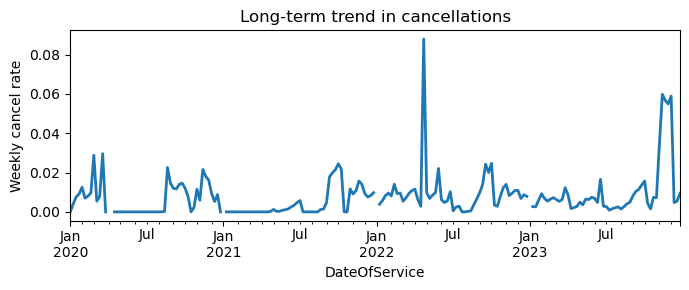

In [38]:
(df_weather2.assign(is_cancel=lambda d: d.CanceledQty.gt(0))
           .set_index('DateOfService')               # or DateOfOrder
           .resample('W')['is_cancel']
           .mean()
           .plot(figsize=(7,3), lw=2))
plt.ylabel('Weekly cancel rate')
plt.title('Long-term trend in cancellations')
plt.tight_layout()


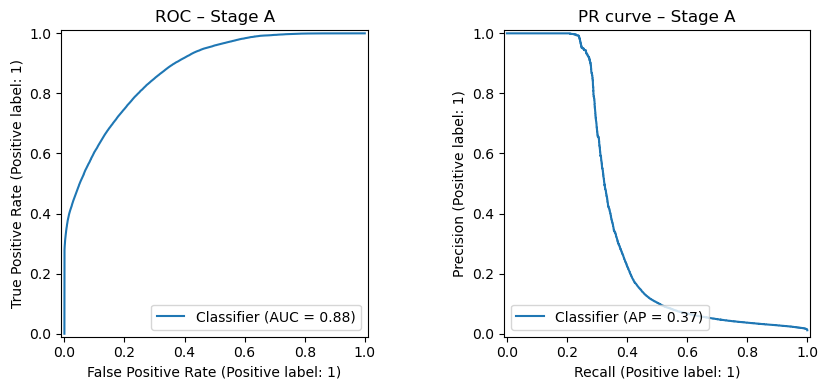

In [41]:
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay

y_true = y_A                       # hold-out ground truth
y_prob = best_A.predict_proba(X_A)[:,1]

fig, ax = plt.subplots(1,2,figsize=(9,4))
RocCurveDisplay.from_predictions(y_true, y_prob, ax=ax[0])
PrecisionRecallDisplay.from_predictions(y_true, y_prob, ax=ax[1])
ax[0].set_title('ROC – Stage A'); ax[1].set_title('PR curve – Stage A')
plt.tight_layout()


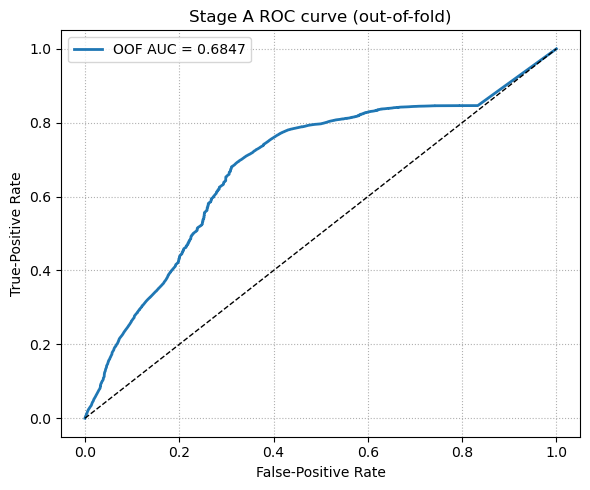

In [51]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import roc_curve, auc
from sklearn.base import clone          # ← add this


tscv      = TimeSeriesSplit(n_splits=5)
oof_prob  = np.zeros(len(X_A))          # will hold P(cancel)
oof_truth = y_A.values                  # make sure it’s a NumPy array

for fold, (tr, te) in enumerate(tscv.split(X_A), 1):
    # ---- 1) fit on the training slice ----
    model = clone(pipeline_A)           # your tuned Stage-A pipeline
    model.fit(X_A.iloc[tr], y_A.iloc[tr])

    # ---- 2) predict probabilities for *this* test slice only ----
    oof_prob[te] = model.predict_proba(X_A.iloc[te])[:, 1]

# ------------------ ROC curve ------------------------
fpr, tpr, _ = roc_curve(oof_truth, oof_prob)
roc_auc     = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, lw=2, label=f'OOF AUC = {roc_auc:0.4f}')
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel('False-Positive Rate'); plt.ylabel('True-Positive Rate')
plt.title('Stage A ROC curve (out-of-fold)')
plt.grid(ls=':')
plt.legend()
plt.tight_layout()
plt.show()


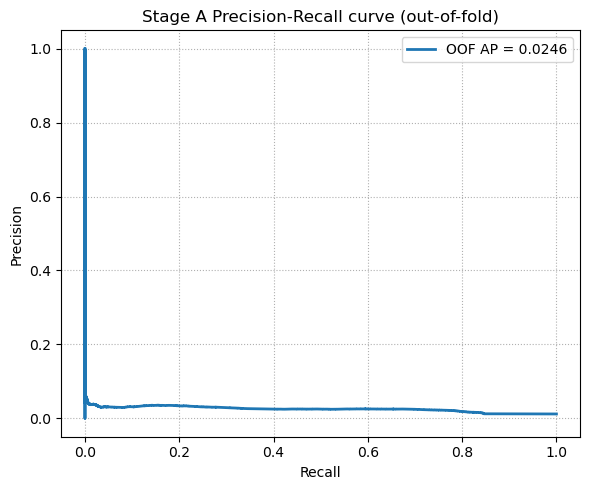

In [52]:
from sklearn.metrics import precision_recall_curve, average_precision_score

prec, rec, _ = precision_recall_curve(oof_truth, oof_prob)
ap = average_precision_score(oof_truth, oof_prob)

plt.figure(figsize=(6, 5))
plt.plot(rec, prec, lw=2, label=f'OOF AP = {ap:0.4f}')
plt.xlabel('Recall'); plt.ylabel('Precision')
plt.title('Stage A Precision-Recall curve (out-of-fold)')
plt.grid(ls=':')
plt.legend(); plt.tight_layout(); plt.show()
